In [1]:
use_gdrive = True # @param {type:"boolean"}

RESULTS_PATH = "results2"

if use_gdrive:
  try:
    # mount your google drive to get permanent storage for your results
    from google.colab import drive
    drive.mount('/content/drive')

    RESULTS_PATH = "/content/drive/MyDrive/infoseclab23/results2"
  except ModuleNotFoundError:
    print("failed to mount gdrive")
else:
  print(f"saving results to '{RESULTS_PATH}'. If you're using Google Colab, this folder will be deleted when you disconnect!")

!mkdir -p {RESULTS_PATH}

Mounted at /content/drive


In [2]:
import sys

# Lab files
![ ! -d 'infoseclab_23' ] && git clone https://github.com/ethz-spylab/infoseclab_23.git
%cd infoseclab_23
!git pull https://github.com/ethz-spylab/infoseclab_23.git
%cd ..
if "infoseclab_23" not in sys.path:
  sys.path.append("infoseclab_23")

Cloning into 'infoseclab_23'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 34 (delta 0), reused 2 (delta 0), pack-reused 30
Receiving objects: 100% (34/34), 268.09 MiB | 38.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (25/25), done.
/content/infoseclab_23
From https://github.com/ethz-spylab/infoseclab_23
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content


# Imports

In [3]:
import infoseclab
from infoseclab import ShadowModels, utils, evaluation
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import scipy
import sklearn
import warnings
from zipfile import ZipFile


# Membership Inference

In this part of the lab, you will create a membership inference attack, with a twist:
you do not know which shadow models were trained on which samples.

First, load the predictions.

In [4]:
# Load data
activations_fit = ShadowModels.activations_fit        # pre-softmax activations from shadow models to construct your attack (50000 x 127 x 10)
activations_attack = ShadowModels.activations_attack  # pre-softmax activations from the target model to attack (50000 x 10)
labels = ShadowModels.labels                          # the class labels of all samples (50000)
training_splits = ShadowModels.training_splits        # train-test vector; -1 for test samples, 1/0 (member/non-member) for training samples (50000)

num_samples, num_models, num_classes = activations_fit.shape
assert activations_attack.shape == (num_samples, num_classes)
assert labels.shape == (num_samples,)
assert training_splits.shape == (num_samples,)

# Mask that is True for all samples with a known target membership label
training_mask = (training_splits != -1)


**Implement your membership inference attack in the following cell.**

Remember that your output should be a NumPy array
containing attack scores for *all* samples,
but we only consider samples where the corresponding `training_mask` entry
is `False` for grading.

The following code performs a dummy attack that ignores all shadow model outputs.

In [5]:
def get_scores(num_samples, num_classes, labels, activations):
  labels_indx = labels.reshape(-1,1)
  anti_label_mask = np.ones((num_samples, num_classes))
  anti_label_mask[np.arange(num_samples)[:, None], labels_indx] = 0
  all_indx = np.repeat(np.arange(num_classes).reshape(1,-1), num_samples, axis=0)
  anti_labels = all_indx[np.where(anti_label_mask)].reshape(num_samples, num_classes-1)

  activations_target = activations[np.arange(num_samples)[:, None], :, labels_indx].squeeze()

  if len(activations_target.shape)==1:
    activations_target = np.expand_dims(activations_target, axis=1)

  activations_rem_max = np.max(activations[np.arange(num_samples)[:, None], :, anti_labels], axis=1)

  logits = activations_target - activations_rem_max
  logits = logits.squeeze()

  return logits

In [6]:
def get_normal_probabilities(x, mean, std):
  term1 = 1/(std*np.sqrt(2*np.pi))
  term2 = np.exp(-0.5*np.square((x-mean)/std))
  prob = np.multiply(term1, term2)
  eps = 1e-10*np.ones_like(prob)

  return prob+eps

In [7]:
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

def get_in_and_out(raw_scores):

  in_mu = np.zeros(len(raw_scores))
  in_std = np.zeros(len(raw_scores))
  out_mu = np.zeros(len(raw_scores))
  out_std = np.zeros(len(raw_scores))

  gmm_global = GaussianMixture(n_components=2, random_state=1)
  gmm_global.fit(raw_scores.reshape(-1,1))

  in_indx = 1
  out_indx = 0
  if gmm_global.means_[0]>gmm_global.means_[1]:
    in_indx=0
    out_indx=1

  in_std_global=np.sqrt(gmm_global.covariances_[in_indx])
  out_std_global=np.sqrt(gmm_global.covariances_[out_indx])

  for i in tqdm(range(len(raw_scores))):
    row_data = raw_scores[i].reshape(-1,1)

    gmm = GaussianMixture(n_components=2, random_state=1)
    gmm.fit(row_data)

    in_indx = 1
    out_indx = 0
    if gmm.means_[0]>gmm.means_[1]:
      in_indx=0
      out_indx=1

    in_mu[i]=gmm.means_[in_indx]
    out_mu[i]=gmm.means_[out_indx]

    in_std[i]=in_std_global
    out_std[i]=out_std_global

  return in_mu, in_std, out_mu, out_std

In [8]:
raw_scores = get_scores(num_samples, num_classes, labels, activations_fit)
in_mu, in_std, out_mu, out_std = get_in_and_out(raw_scores)

100%|██████████| 50000/50000 [05:43<00:00, 145.56it/s]


In [9]:
attack_raw_scores = get_scores(num_samples, num_classes, labels, np.expand_dims(activations_attack, axis=1))
prob_in = get_normal_probabilities(attack_raw_scores, in_mu, in_std)
prob_out = get_normal_probabilities(attack_raw_scores, out_mu, out_std)
lamda = prob_in/prob_out

In [10]:
# TODO: Replace the following dummy score with your attack
# attack_scores = activations_attack[np.arange(num_samples), labels]
attack_scores = lamda.astype(np.float32)

# Save scores
utils.save_attack_scores(os.path.join(RESULTS_PATH, "attack_scores.npy"), attack_scores)

Dummy attack TPR @ FPR 1.00%: 11.35%


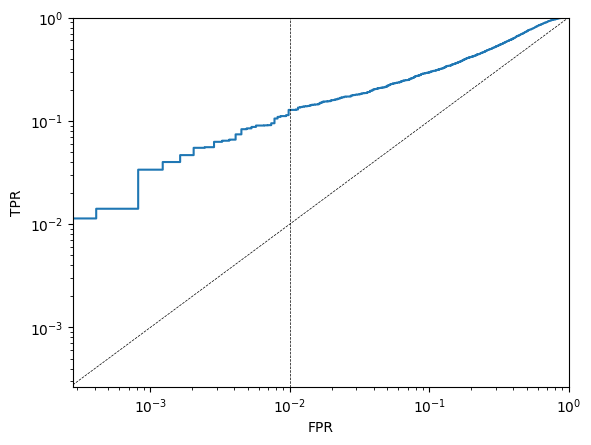

In [11]:
# You can visualize the TPR vs. FPR of your attack on the training set using the following code.
# If you want to evaluate multiple attacks you can call `evaluation.eval_mia` multiple times,
# but you should set `plot_decorations = False` for all but the first call.
fig, ax = plt.subplots()
evaluation.eval_mia(
    true_splits=training_splits[training_mask],
    attack_scores=attack_scores[training_mask],
    ax=ax,
    label="Dummy attack",
    plot_decorations=True,
)
plt.show(fig)
plt.close(fig)

# Stealing Chatbot Prompts

Enter results for the chatbot secret extraction

In [12]:
# Enter your 10 extracted secrets, 6 alphanumeric characters each
secrets = [
    "TIOsxG",
    "ur71Ct",
    "x7yQxM",
    "3PiGUk",
    "TZoP2i",
    "NofQK8",
    "6gTiO0",
    "pss410",
    "j7xE6h",
    "hmaPiB"
]

# save the secrets to an array and save it to chatbot.npy
secrets = np.array(secrets)
assert len(secrets) == 10
np.save(f"{RESULTS_PATH}/chatbot.npy", secrets)

# Create submission file (**upload `results2.zip` to moodle**)

In [13]:
!zip -j -FSr "{RESULTS_PATH}/results2.zip" {RESULTS_PATH}

  adding: attack_scores.npy (deflated 10%)
  adding: chatbot.npy (deflated 52%)


In [14]:
from infoseclab.submission import validate_zip2
assert validate_zip2(f"{RESULTS_PATH}/results2.zip")

Zip file is valid
